## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from tqdm import tqdm # for nice progress bars
import math
from sklearn.metrics import confusion_matrix

In [2]:
np.random.seed(20030403)
np.set_printoptions(precision=2) # 2 decimal places for numpy

## Datasets

In [3]:
rings3_regular_train = pd.read_csv('../../classification/rings3-regular-training.csv')
easy_train = pd.read_csv('../../classification/easy-training.csv')
xor3_train = pd.read_csv('../../classification/xor3-training.csv')

rings3_regular_test = pd.read_csv('../../classification/rings3-regular-test.csv')
easy_test = pd.read_csv('../../classification/easy-test.csv')
xor3_test = pd.read_csv('../../classification/xor3-test.csv')


datasets = [rings3_regular_train, easy_train, xor3_train]


## Helper Functions and classes

In [4]:
def relu(x, derivative=False):
    if derivative:
        return np.where(x > 0, 1, 0)
    return np.maximum(0, x)

def sigmoidal(x, derivative=False):
    x_safe = np.clip(x, -500, 500) # aby nie bylo overflow
    s = 1 / (1 + np.exp(-x_safe))
    if derivative:
        return s * (1 - s)
    return s

def linear(x, derivative=False):
    if derivative:
        return np.ones_like(x)
    return x

def softmax(x, derivative=False):
    shift_x = x - np.max(x, axis=1, keepdims=True)
    exps = np.exp(shift_x)
    s = exps / np.sum(exps, axis=1, keepdims=True)
    if derivative:
        return s * (1 - s)
    return s

In [5]:

def plot_data(data_x, data_y, data_c):
    plt.figure(figsize=(10, 8))
    
    scatter = plt.scatter(data_x, data_y, c=data_c, cmap='viridis', 
                         alpha=0.7, edgecolor='k', s=50)
    cbar = plt.colorbar(scatter)
    cbar.set_label('c value')
    unique_c = np.unique(data_c)
    if len(unique_c) <= 10:
        cmap = plt.cm.viridis
        norm = plt.Normalize(min(data_c), max(data_c))
        legend_elements = [Line2D([0], [0], marker='o', color='w', 
                          markerfacecolor=cmap(norm(value)), markersize=10, 
                          label=f'c = {value}') 
                          for value in unique_c]
        plt.legend(handles=legend_elements, title='c Values')
    plt.title('Scatter Plot (x, y) with Points Colored by c Values')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('rings3_scatter_plot.png')
    plt.show()

In [6]:
class StandardScaler:
    def __init__(self):
        self.mean = None
        self.sd = None
    
    def fit(self, data): 
        self.mean = np.mean(data, axis=0)
        self.sd = np.std(data, axis=0)
    
    def transform(self, data):
        return (data - self.mean) / self.sd
    
    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)
    
    def inverse_transform(self, data):
        return data * self.sd + self.mean

In [7]:
def f_score(y_true, y_pred, average="macro"):
    labels = np.unique(y_true)
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    TP = np.diag(cm)
    FP = np.sum(cm, axis=0) - TP
    FN = np.sum(cm, axis=1) - TP

    epsilon = 1e-9 # unikamy dzielenia prze 0
    precision = TP / (TP + FP + epsilon)
    recall = TP / (TP + FN + epsilon)
    f1 = 2 * (precision * recall) / (precision + recall + epsilon)

    if average == "macro":
        return np.mean(f1)
    elif average == "micro":
        total_TP = np.sum(TP)
        total_FP = np.sum(FP)
        total_FN = np.sum(FN)
        return 2 * total_TP / (2 * total_TP + total_FP + total_FN + epsilon)
    elif average == "weighted":
        weights = np.sum(cm, axis=1) / np.sum(cm)
        return np.sum(f1 * weights)
    else:
        return f1
    
def plot_predictions(data_x, y_true, y_pred):
    data_x = np.array(data_x)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    correct = (y_true == y_pred)
    
    plt.figure(figsize=(10, 8))
    plt.scatter(data_x[correct, 0], data_x[correct, 1], 
                color='green', alpha=0.7, edgecolor='k', s=50, label='Correct')
    plt.scatter(data_x[~correct, 0], data_x[~correct, 1], 
                color='red', alpha=0.7, edgecolor='k', s=50, label='Incorrect')
    
    plt.title('Prediction Comparison: Correct (green) vs Incorrect (red)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('prediction_comparison.png')
    plt.show()

def one_hot_encode(labels, num_classes):
    labels = np.array(labels)
    one_hot_matrix = np.zeros((len(labels), num_classes), dtype=int)
    
    for i, label in enumerate(labels):
        one_hot_matrix[i, label] = 1
    
    return one_hot_matrix

# Data plots

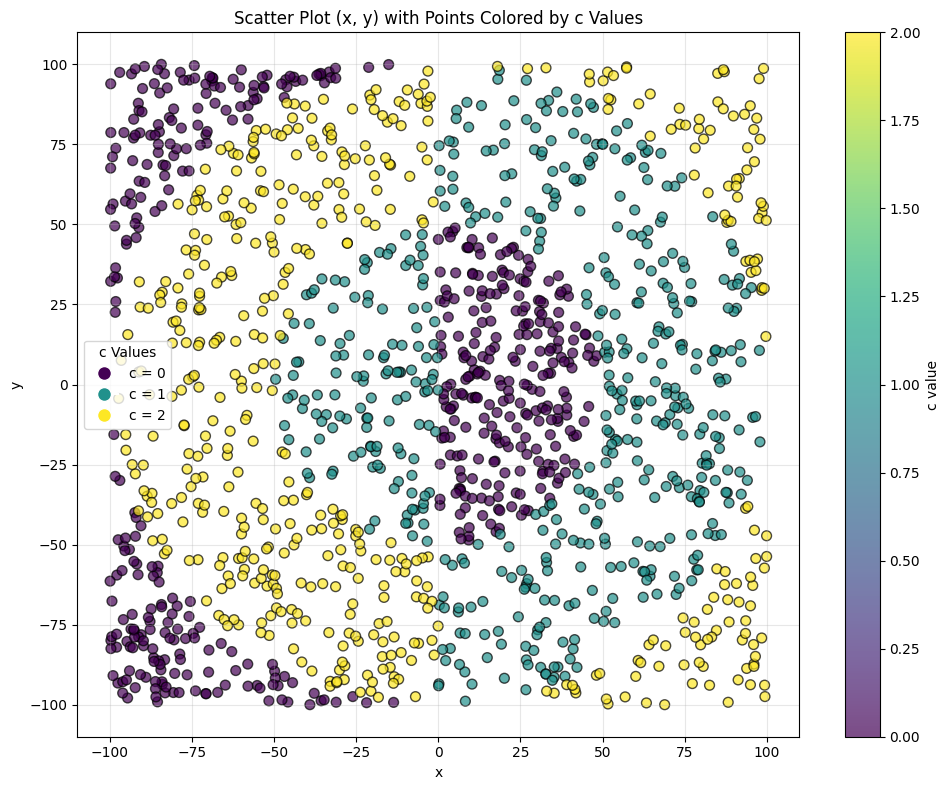

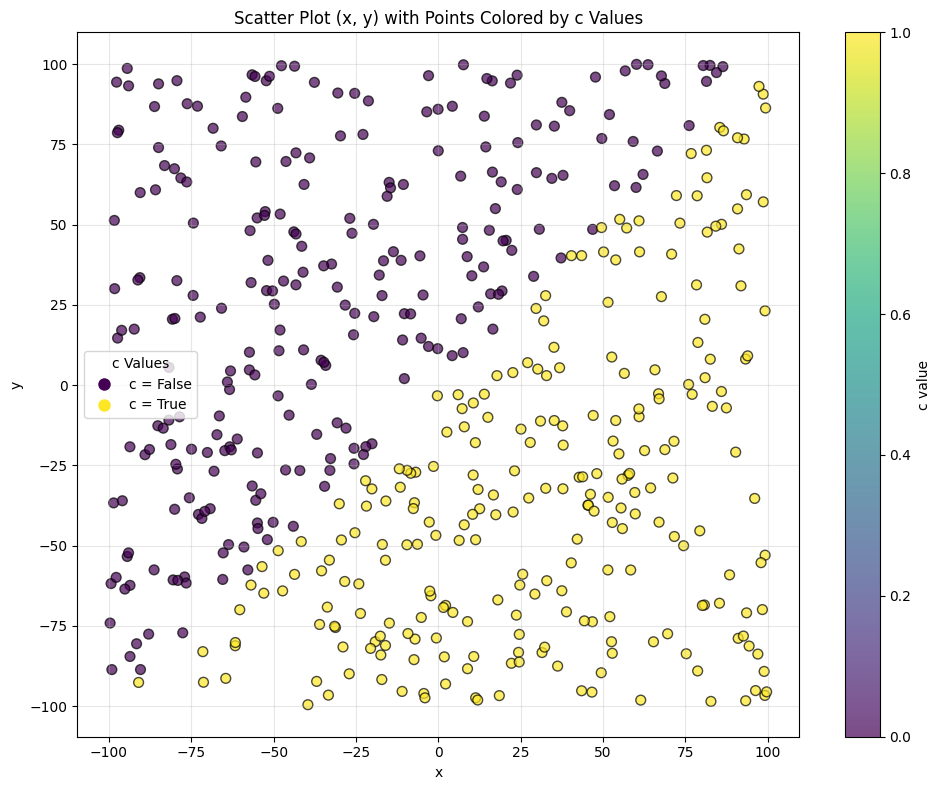

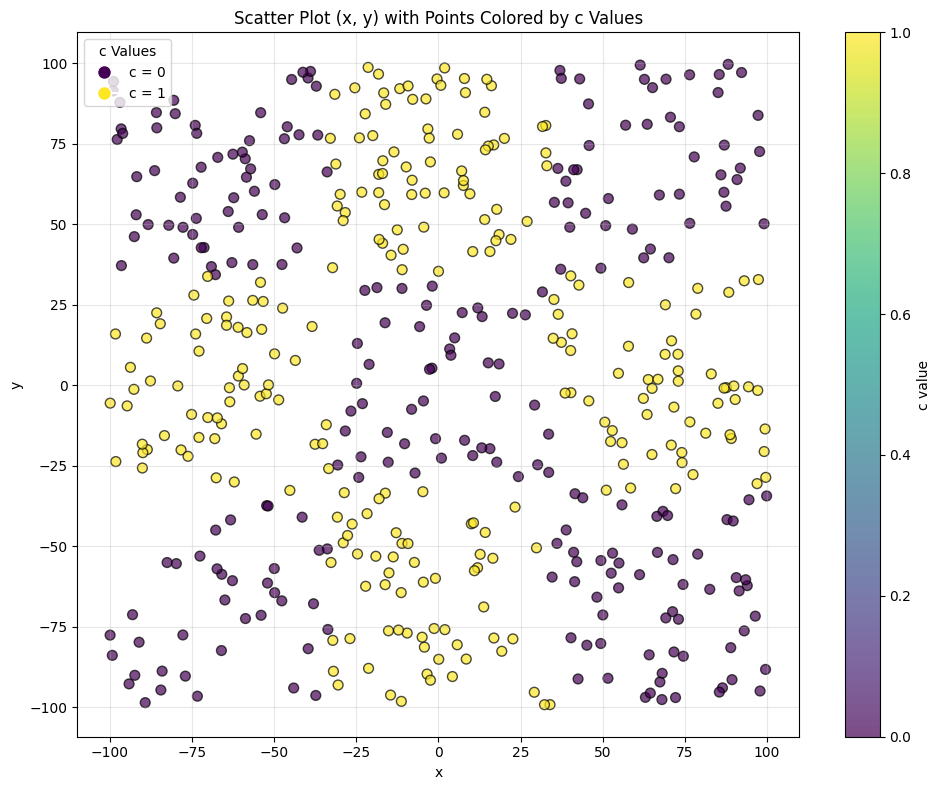

In [8]:
for dataset in datasets:
    plot_data(dataset['x'], dataset['y'], dataset['c'])

# MLP backprop + moment + normalizacja + softmax

In [9]:
class MLPBackprop:
    def __init__(self, layers, 
                 hidden_activation_function='sigmoid', 
                 output_activation_function='sigmoid', 
                 starting_weights=None, 
                 starting_biases=None,
                 momentum=0.0,            
                 rmsprop_decay=0.0,   
                 rmsprop_epsilon=1e-8):     
        
        self.layers = layers
        self.weights = []
        self.biases = []
        self.print_epoch = True
        self.weight_history = []
        self.bias_history = []
        activation_functions = {"relu": relu, "sigmoid": sigmoidal, "linear": linear, "softmax": softmax}
        
        if hidden_activation_function in activation_functions:
            self.hidden_activation_function = activation_functions[hidden_activation_function]
        else:
            raise ValueError("Invalid hidden activation function, choose from:", activation_functions)
        
        if output_activation_function in activation_functions:
            self.output_activation_function = activation_functions[output_activation_function]
        else:
            raise ValueError("Invalid output activation function, choose from:", activation_functions)
        
        self.momentum = momentum
        self.rmsprop_decay = rmsprop_decay
        self.rmsprop_epsilon = rmsprop_epsilon
        
        for i in range(len(self.layers) - 1):
            n_input = self.layers[i]
            n_output = self.layers[i + 1]
            
            activation_function = self.hidden_activation_function if i < len(self.layers) - 2 else self.output_activation_function
            
            if activation_function == sigmoidal:  # Xavier initialization 
                weight_matrix = np.random.normal(0, np.sqrt(2 / (n_input + n_output)), size=(n_input, n_output))
            elif activation_function == relu:  # He initialization
                weight_matrix = np.random.uniform(- np.sqrt(2 / n_input), np.sqrt(2 / n_input), size=(n_input, n_output))
            else:
                weight_matrix = np.random.randn(n_input, n_output)
            self.weights.append(weight_matrix)
            self.biases.append(np.zeros((1, n_output)))
        
        if self.momentum > 0:
            self.weight_velocities = [np.zeros_like(w) for w in self.weights]
            self.bias_velocities = [np.zeros_like(b) for b in self.biases]
        
        if self.rmsprop_decay > 0:
            self.weight_cache = [np.zeros_like(w) for w in self.weights]
            self.bias_cache = [np.zeros_like(b) for b in self.biases]
    
    def forward(self, X):
        if isinstance(X, np.ndarray) and X.ndim == 1:
            X = X.reshape(-1, 1)
        
        self.z_values = []
        self.activations = [X]
        activation = X
        
        for i in range(len(self.weights) - 1):
            z = np.dot(activation, self.weights[i]) + self.biases[i]
            self.z_values.append(z)
            activation = self.hidden_activation_function(z)
            self.activations.append(activation)
            
        z = np.dot(activation, self.weights[-1]) + self.biases[-1]
        self.z_values.append(z)
        output = self.output_activation_function(z)
        self.activations.append(output)
        return output
    
    def predict(self, X):
        if isinstance(X, np.ndarray) and X.ndim == 1:
            X = X.reshape(-1, 1)
        return self.forward(X)
    
    def backpropagation(self, X, y, learning_rate=0.01):
        if isinstance(X, np.ndarray) and X.ndim == 1:
            X = X.reshape(1, -1)
        if isinstance(y, np.ndarray) and y.ndim == 1:
            y = y.reshape(1, -1)
        
        N = X.shape[0]
        output = self.forward(X)
        
        d_loss = (output - y) / N
        
        if self.output_activation_function in [sigmoidal, relu]:
            delta = d_loss * self.output_activation_function(self.z_values[-1], derivative=True)
        elif self.output_activation_function == softmax:
            delta = d_loss
        else:
            delta = d_loss
            
        deltas = [delta]
        
        for i in range(len(self.weights) - 1, 0, -1):
            delta = np.dot(deltas[0], self.weights[i].T) * self.hidden_activation_function(self.z_values[i-1], derivative=True)
            deltas.insert(0, delta)
        
        for i in range(len(self.weights)):
            grad_w = np.dot(self.activations[i].T, deltas[i])
            grad_b = np.sum(deltas[i], axis=0, keepdims=True)
            
            if self.rmsprop_decay > 0:
                self.weight_cache[i] = self.rmsprop_decay * self.weight_cache[i] + (1 - self.rmsprop_decay) * (grad_w ** 2)
                self.bias_cache[i] = self.rmsprop_decay * self.bias_cache[i] + (1 - self.rmsprop_decay) * (grad_b ** 2)
                adjusted_grad_w = grad_w / (np.sqrt(self.weight_cache[i]) + self.rmsprop_epsilon)
                adjusted_grad_b = grad_b / (np.sqrt(self.bias_cache[i]) + self.rmsprop_epsilon)
            else:
                adjusted_grad_w = grad_w
                adjusted_grad_b = grad_b
            
            if self.momentum > 0:
                self.weight_velocities[i] = self.momentum * self.weight_velocities[i] + learning_rate * adjusted_grad_w
                self.bias_velocities[i] = self.momentum * self.bias_velocities[i] + learning_rate * adjusted_grad_b
                self.weights[i] -= self.weight_velocities[i]
                self.biases[i] -= self.bias_velocities[i]
            else:
                self.weights[i] -= learning_rate * adjusted_grad_w
                self.biases[i] -= learning_rate * adjusted_grad_b

    def train(self, X, y, epochs=1000, learning_rate=0.02, batch_size=0):
        if isinstance(X, np.ndarray) and X.ndim == 1:
            X = X.reshape(1, -1)
        if isinstance(y, np.ndarray) and y.ndim == 1:
            y = y.reshape(1, -1)
        
        best_loss = np.inf
        self.loss_history = []
        best_weights = None
        best_biases = None
        self.weight_history = []

        progress_bar = tqdm(range(epochs), desc="Training")

        for epoch in progress_bar:
            if batch_size == 0:
                self.backpropagation(X, y, learning_rate)
            else:
                indices = np.random.permutation(X.shape[0])
                X_shuffled = X[indices]
                y_shuffled = y[indices]
                
                for i in range(0, X.shape[0], batch_size):
                    X_batch = X_shuffled[i:i + batch_size]
                    y_batch = y_shuffled[i:i + batch_size]
                    self.backpropagation(X_batch, y_batch, learning_rate)
            
            predictions = self.predict(X)
            loss = np.mean(np.square(y - predictions))
            
            if loss < best_loss:
                best_loss = loss
                best_weights = [w.copy() for w in self.weights]
                best_biases = [b.copy() for b in self.biases]
            
            loss = np.mean(np.square(y - self.predict(X)))
            self.loss_history.append(loss)
            current_weights = [w.copy() for w in self.weights]
            current_biases = [b.copy() for b in self.biases]
            self.weight_history.append(current_weights)
            self.bias_history.append(current_biases)
            
            progress_bar.set_postfix(loss=f"{loss:.6f}")
        
        self.weights = best_weights
        self.biases = best_biases
        print(f'Best loss: {best_loss}')

    def set_weights_and_biases(self, layer_idx, w, b):
        self.weights[layer_idx] = w
        self.biases[layer_idx] = b
    
    def mse(self, y_true, y_pred):
        return np.mean((y_true - y_pred) ** 2)

    def plot_history(self, figsize=(15, 10), save_path=None, max_neurons_per_plot=10):
        if not self.weight_history:
            raise ValueError("No weight history available. Train the network first.")
        
        num_layers = len(self.weights)
        num_epochs = len(self.weight_history)
        epochs = np.arange(num_epochs)
        
        total_subplots = num_layers * 2 + 1
        
        cols = min(2, total_subplots)
        rows = math.ceil(total_subplots / cols)
        
        fig, axes = plt.subplots(rows, cols, figsize=figsize)
        
        if total_subplots > 1:
            axes = axes.flatten()
        else:
            axes = [axes]
        
        subplot_idx = 0
        
        ax_loss = axes[subplot_idx]
        subplot_idx += 1
        
        ax_loss.plot(epochs, self.loss_history, '-', linewidth=2, label='Training Loss')
        if hasattr(self, 'val_loss_history') and self.val_loss_history:
            ax_loss.plot(epochs, self.val_loss_history, '-', linewidth=2, label='Validation Loss')
        
        ax_loss.set_title('Loss History')
        ax_loss.set_xlabel('Epoch')
        ax_loss.set_ylabel('Loss (MSE)')
        ax_loss.grid(True, alpha=0.3)
        ax_loss.legend()
        
        for layer_idx in range(num_layers):
            input_size, output_size = self.weights[layer_idx].shape
            ax_weights = axes[subplot_idx]
            subplot_idx += 1
            
            total_weights = input_size * output_size
            if total_weights > max_neurons_per_plot:
                indices_flat = np.random.choice(total_weights, max_neurons_per_plot, replace=False)
                indices = [(idx // output_size, idx % output_size) for idx in indices_flat]
            else:
                indices = [(i, j) for i in range(input_size) for j in range(output_size)]
            
            for i, j in indices:
                weight_values = [self.weight_history[epoch][layer_idx][i, j] for epoch in range(num_epochs)]
                ax_weights.plot(epochs, weight_values, '-', linewidth=1, 
                            label=f'w_{i+1},{j+1}' if total_weights <= 20 else None)
            
            ax_weights.set_title(f'Layer {layer_idx+1}: Weights')
            ax_weights.set_xlabel('Epoch')
            ax_weights.set_ylabel('Weight Value')
            ax_weights.grid(True, alpha=0.3)
            if total_weights <= 20:
                ax_weights.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            
            ax_biases = axes[subplot_idx]
            subplot_idx += 1
            
            bias_size = self.biases[layer_idx].shape[1]
            if bias_size > max_neurons_per_plot:
                bias_indices = np.random.choice(bias_size, max_neurons_per_plot, replace=False)
            else:
                bias_indices = range(bias_size)
            
            for j in bias_indices:
                bias_values = [self.bias_history[epoch][layer_idx][0, j] for epoch in range(num_epochs)]
                ax_biases.plot(epochs, bias_values, '-', linewidth=1, 
                            label=f'b_{j+1}' if bias_size <= 20 else None)
            
            ax_biases.set_title(f'Layer {layer_idx+1}: Biases')
            ax_biases.set_xlabel('Epoch')
            ax_biases.set_ylabel('Bias Value')
            ax_biases.grid(True, alpha=0.3)
            if bias_size <= 20:
                ax_biases.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
        for i in range(subplot_idx, len(axes)):
            axes[i].axis('off')
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path)
        
        plt.show()

# Testing on data

## Rings 3 regular

In [10]:
X_train, y_train = rings3_regular_train[["x","y"]], rings3_regular_train["c"].astype(int)
X_test, y_test = rings3_regular_test[["x","y"]], rings3_regular_test["c"].astype(int)
standard_scaler_easy = StandardScaler()
X_train_scaled = standard_scaler_easy.fit_transform(X_train)
y_train_encoded = one_hot_encode(y_train, 3)
X_test_scaled = standard_scaler_easy.fit_transform(X_test)

Training: 100%|██████████| 10000/10000 [00:25<00:00, 399.77it/s, loss=0.009792]


Best loss: 0.009587580956747823
F1 Score: 0.983999999999672


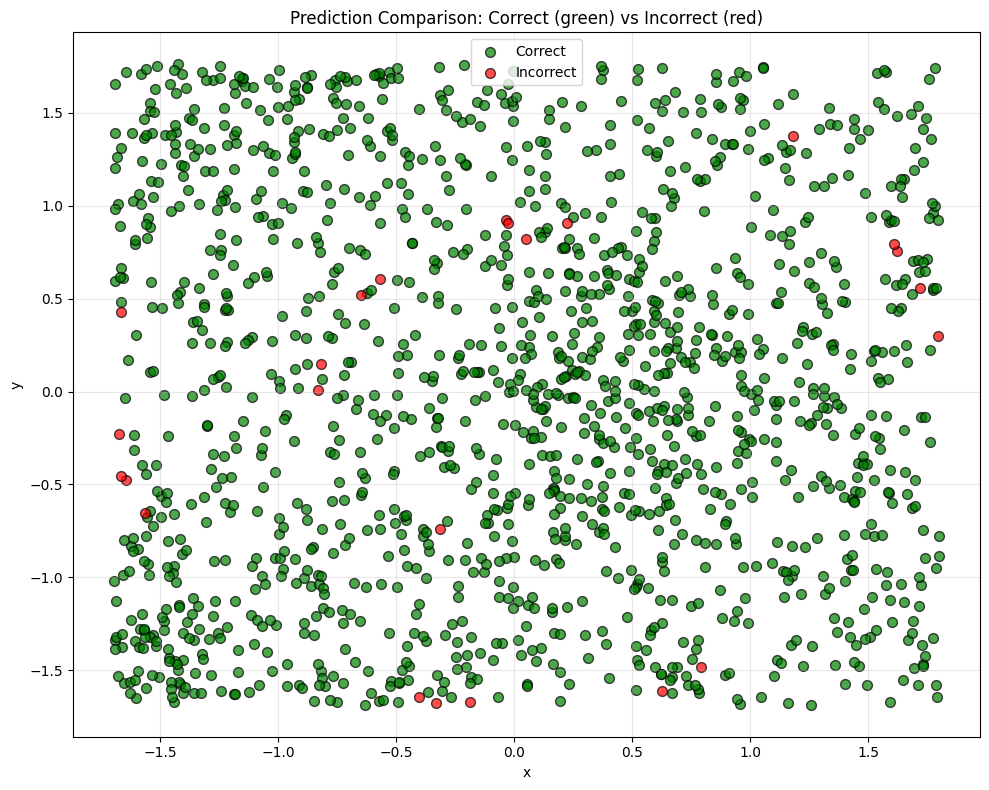

In [11]:
input_dim = X_train_scaled.shape[1]
output_dim = y_train_encoded.shape[1]

model = MLPBackprop(layers=[input_dim, 12, output_dim],
                    hidden_activation_function='sigmoid',
                    output_activation_function='softmax', rmsprop_decay=0.9)

model.train(X_train_scaled, y_train_encoded, epochs=10000, learning_rate=0.02, batch_size=0)

predictions = model.predict(X_train_scaled)

predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_train_encoded, axis=1)

fscore = f_score(true_classes, predicted_classes, average='micro')
print("F1 Score:", fscore)


plot_predictions(X_train_scaled, true_classes, predicted_classes)

## Easy Train

In [12]:
X_train, y_train = easy_train[["x","y"]], easy_train["c"].astype(int)
X_test, y_test = easy_test[["x","y"]], easy_test["c"].astype(int)
standard_scaler_easy = StandardScaler()
X_train_scaled = standard_scaler_easy.fit_transform(X_train)
y_train_encoded = one_hot_encode(y_train, 2)
X_test_scaled = standard_scaler_easy.fit_transform(X_test)

Training: 100%|██████████| 10000/10000 [00:17<00:00, 575.60it/s, loss=0.000001]


Best loss: 7.388898886229588e-08
F1 Score: 0.999999999999


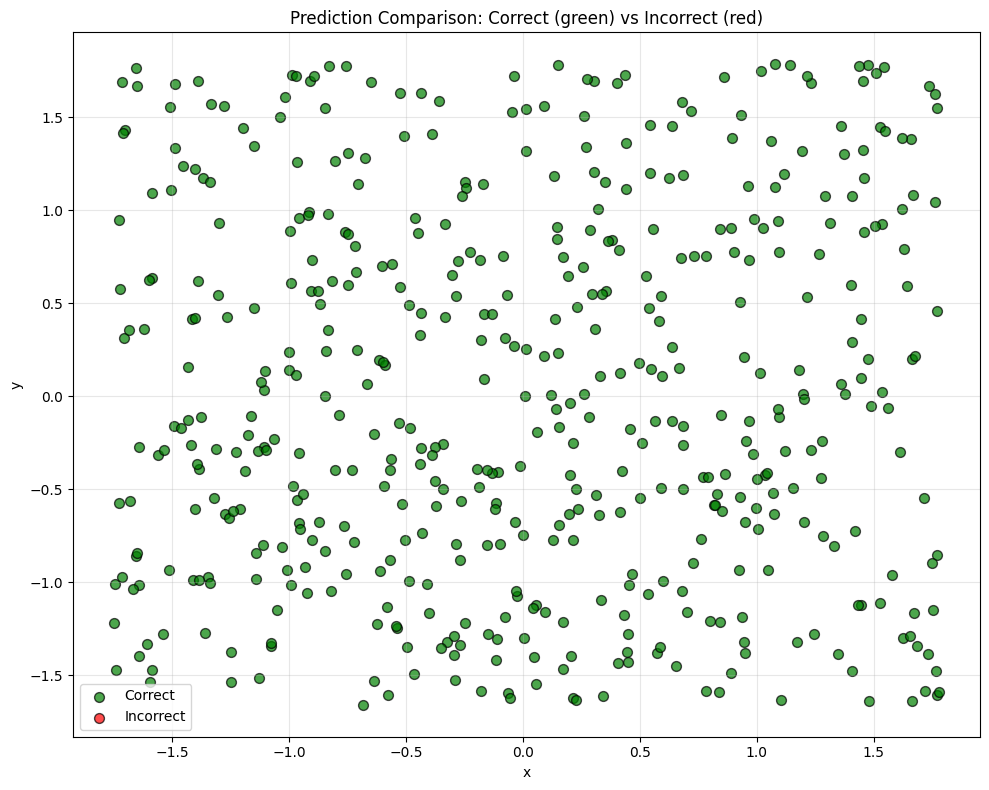

In [13]:
input_dim = X_train_scaled.shape[1]
output_dim = y_train_encoded.shape[1]

model = MLPBackprop(layers=[input_dim, 12, output_dim],
                    hidden_activation_function='sigmoid',
                    output_activation_function='softmax', rmsprop_decay=0.9)

model.train(X_train_scaled, y_train_encoded, epochs=10000, learning_rate=0.02, batch_size=0)

predictions = model.predict(X_train_scaled)

predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_train_encoded, axis=1)

fscore = f_score(true_classes, predicted_classes, average='micro')
print("F1 Score:", fscore)


plot_predictions(X_train_scaled, true_classes, predicted_classes)

## XOR3

In [14]:
X_train, y_train = xor3_train[["x","y"]], xor3_train["c"].astype(int)
X_test, y_test = xor3_test[["x","y"]], xor3_test["c"].astype(int)
standard_scaler_easy = StandardScaler()
X_train_scaled = standard_scaler_easy.fit_transform(X_train)
y_train_encoded = one_hot_encode(y_train, 2)
X_test_scaled = standard_scaler_easy.fit_transform(X_test)

Training: 100%|██████████| 10000/10000 [00:21<00:00, 462.31it/s, loss=0.011247]


Best loss: 0.010334094082322292
F1 Score: 0.991999999999008


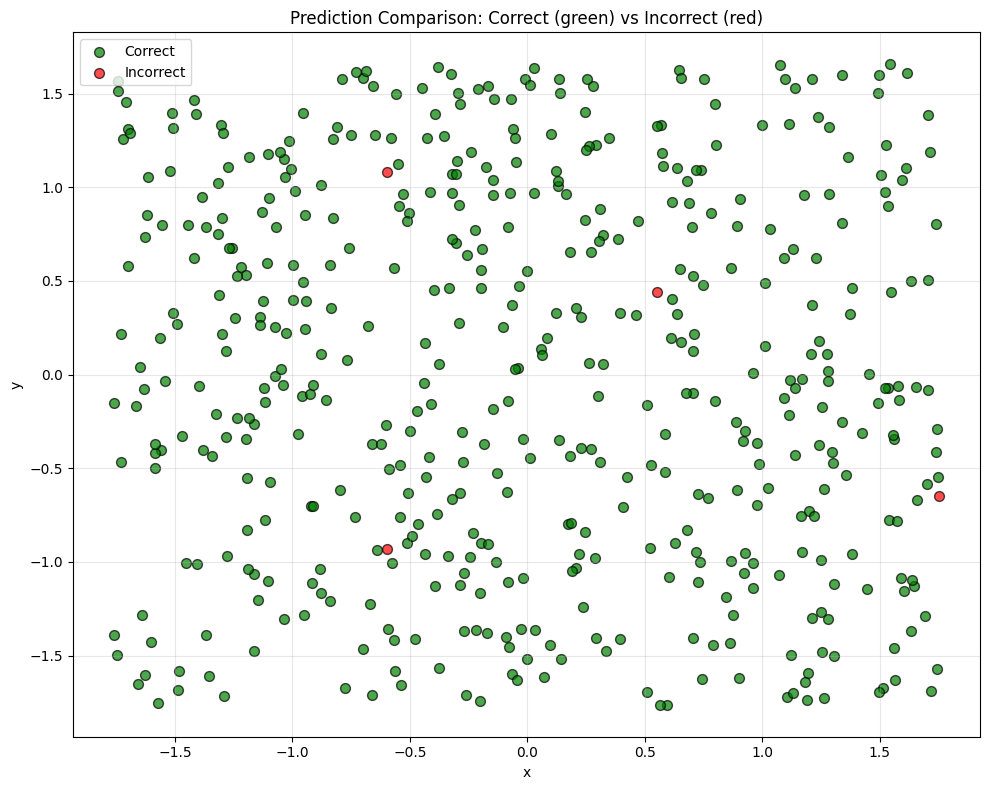

In [15]:
input_dim = X_train_scaled.shape[1]
output_dim = y_train_encoded.shape[1]

model = MLPBackprop(layers=[input_dim, 12, output_dim],
                    hidden_activation_function='sigmoid',
                    output_activation_function='softmax', rmsprop_decay=0.9)

model.train(X_train_scaled, y_train_encoded, epochs=10000, learning_rate=0.02, batch_size=0)

predictions = model.predict(X_train_scaled)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_train_encoded, axis=1)

fscore = f_score(true_classes, predicted_classes, average='micro')
print("F1 Score:", fscore)

plot_predictions(X_train_scaled, true_classes, predicted_classes)